In [1]:
import numpy as np

from system import (
    s_state,
    t_state,
    rows,
    cols,
    states,
    actions,
    num_states,
    num_actions,
    wind_col,
    to_idx,
    to_state,
    get_valid_actions,
    init_mdp,
    init_reward,
)
from model import Model
from policy import Policy, PolicyInit
from agent import Agent

In [2]:
def Contraction(valf: np.ndarray, model: Model, gamma=1.0):
    delta = 0
    for s in states:
        v = valf[to_idx(s)]
        valid_actions_idx = get_valid_actions(s)
        valf[to_idx(s)] = np.max(
            [
                model.prob(s, a) @ (model.get_reward(s) + gamma * valf)
                for a in valid_actions_idx
            ]
        )
        delta = max(delta, abs(v - valf[to_idx(s)]))
    return delta, valf

In [3]:
def GetPolicy(valf: np.ndarray, model: Model, gamma=1.0):
    policy = Policy(num_states, num_actions, PolicyInit.RANDOM)

    for s in states:
        valid_actions_idx = get_valid_actions(s)
        action_value = [
            model.prob(s, a) @ (model.get_reward(s) + gamma * valf)
            for a in valid_actions_idx
        ]
        amzt = valid_actions_idx[np.argmax(action_value)]
        policy.update(s, amzt, 1)
        policy.set_action(s, amzt)
    return policy

In [4]:
# Initialize model
mdp = init_mdp(num_states, num_actions, wind_col)
reward = init_reward(num_states, t_reward=0)
model = Model(mdp, reward)

In [5]:
valf = np.zeros(num_states)
valstart = []
# valf[to_idx(t_state)] = 0

thresh = 0.001
gamma = 0.1

delta = thresh + 1
i = 0

while delta > thresh and i < 1000:
    print(f"Value Iteration {i + 1}")

    # Apply contraction mapping
    delta, valf = Contraction(valf, model, gamma=gamma)
    valstart.append(valf[to_idx(s_state)])
    # Print delta
    print(f"Delta: {delta}")
    i+=1

policy = GetPolicy(valf, model)
np.save("OptimalValueFunction.npy", valf)

Value Iteration 1
Delta: 1.0713077818930041
Value Iteration 2
Delta: 0.10689545281207136
Value Iteration 3
Delta: 0.010689545281207025
Value Iteration 4
Delta: 0.0010689545281206136
Value Iteration 5
Delta: 0.00010619318242821585


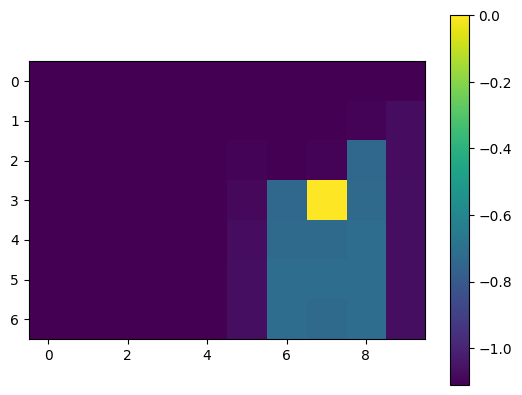

In [6]:
import matplotlib.pyplot as plt
valf_toplot = valf.reshape(rows, cols)
plt.gca().invert_yaxis()
heatmap = plt.imshow(valf_toplot)
plt.colorbar(heatmap)
plt.show()

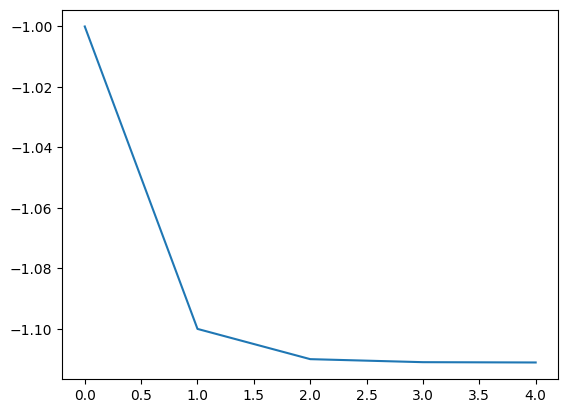

In [7]:
valstart = np.array(valstart)
plt.plot(valstart)

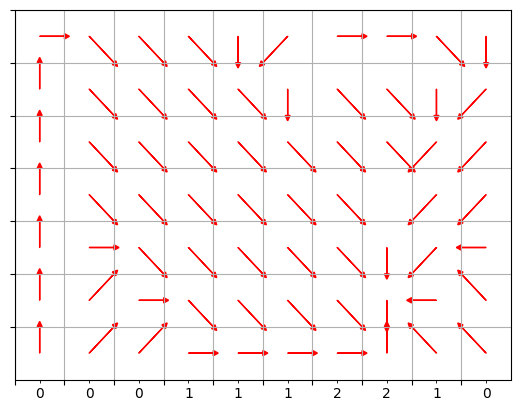

In [8]:
ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

# ## plot 8 types arrows in each grid cell corresponding to the action in the optimal policy
# 0: up-left, 1:up, 2: up-right, 3: left,4: right,5:down-left,6:down,7:down-right
for i in range(rows):
    for j in range(cols):
        s = np.array([i, j])
        if i == t_state[0] and j == t_state[1]:
            continue
        action = policy.get_action(s)
        x_start = j + 0.5  # x-coordinate shifted to the middle of the grid cell
        y_start = i + 0.5  # y-coordinate shifted to the middle of the grid cell
        
        if action == 0:
            plt.arrow(x_start, y_start, -0.5, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 1:
            plt.arrow(x_start, y_start, 0, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 2:
            plt.arrow(x_start, y_start, 0.5, -0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 3:
            plt.arrow(x_start, y_start, -0.5, 0, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 4:
            plt.arrow(x_start, y_start, 0.5, 0, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 5:
            plt.arrow(x_start, y_start, -0.5, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 6:
            plt.arrow(x_start, y_start, 0, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')
        elif action == 7:
            plt.arrow(x_start, y_start, 0.5, 0.5, head_width=0.1, head_length=0.1, fc='r', ec='r')


In [9]:
agent = Agent(model, policy)
path, score = agent.play(model, policy, np.array([3,0]), 1000)

State: [3 0], Action: [-1  0], Next State: [2 0], Reward: -1
State: [2 0], Action: [-1  0], Next State: [1 0], Reward: -1
State: [1 0], Action: [-1  0], Next State: [0 0], Reward: -1
State: [0 0], Action: [0 1], Next State: [0 1], Reward: -1
State: [0 1], Action: [1 1], Next State: [1 2], Reward: -1
State: [1 2], Action: [1 1], Next State: [2 3], Reward: -1
State: [2 3], Action: [1 1], Next State: [3 4], Reward: -1
State: [3 4], Action: [1 1], Next State: [2 5], Reward: -1
State: [2 5], Action: [1 1], Next State: [3 6], Reward: -1
State: [3 6], Action: [1 1], Next State: [2 7], Reward: -1
State: [2 7], Action: [1 1], Next State: [1 8], Reward: -1
State: [1 8], Action: [1 0], Next State: [2 8], Reward: -1
State: [2 8], Action: [ 1 -1], Next State: [1 7], Reward: -1
State: [1 7], Action: [1 1], Next State: [0 8], Reward: -1
State: [0 8], Action: [1 1], Next State: [0 9], Reward: -1
State: [0 9], Action: [1 0], Next State: [1 9], Reward: -1
State: [1 9], Action: [ 1 -1], Next State: [2 8]

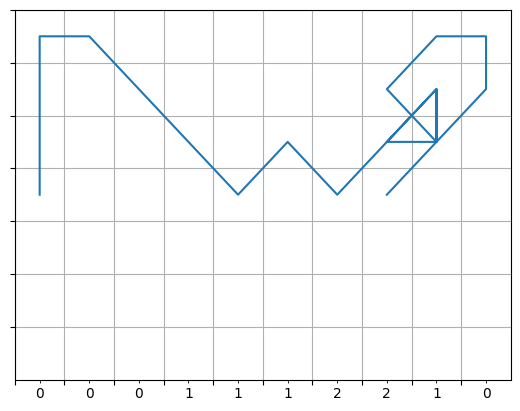

In [10]:
path_plt = np.array(path) + 0.5
y, x = path_plt.T

ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

ax.plot(x, y)
plt.show()